# MANA BIO Assignment 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks
import re
import html
import numpy as np
from wordcloud import WordCloud
from gensim import corpora
from nltk.tokenize import word_tokenize
import nltk
from gensim.models import LdaModel

In [2]:
# loading stop words for text processing
with open('stop_words_english.txt', 'r') as file:
    stop_words = set([line.strip() for line in file])

In [3]:
# path to the data file, should be changed, if run locally
data_path = '/Users/yudkin/Documents/mana_bio/reddit_data.csv'

In [4]:
df = pd.read_csv(data_path)
df['body'] = df['body'].astype(str)
df['author'] = df['author'].astype(str)
df['created_utc'] = pd.to_datetime(df['created_utc'])
df['date'] = df['created_utc'].dt.date
df['subreddit'] = df['subreddit'].str.lower()

# Cleanng and some basic data visualizations

In [5]:
print(f'Total {len(df)} rows before processing the data')

Total 558353 rows before processing the data


In [6]:
df.head(20)

,author,body,created_utc,subreddit,id,score,date
0,malcontent,&gt;The business cannot survive paying out ben...,2008-12-18 08:00:37,politics,2,1,2008-12-18
1,malcontent,"&gt;I'm curious, how do you see, beyond defini...",2008-12-18 08:00:41,politics,3,1,2008-12-18
2,malcontent,"&gt;I'm curious, how do you see, beyond defini...",2008-12-18 08:00:53,politics,4,2,2008-12-18
3,[deleted],[deleted],2008-12-18 08:01:07,wtf,5,1,2008-12-18
4,catalytica,The greatest historic instigator of human divi...,2008-12-18 08:01:20,atheism,7,0,2008-12-18
5,jz_,Looking forward to\n\n* writing more tests for...,2008-12-18 08:01:24,programming,8,2,2008-12-18
6,JasonDJ,&gt; Over 75 percent of films in the top 50 we...,2008-12-18 08:01:32,wtf,a,7,2008-12-18
7,[deleted],[deleted],2008-12-18 08:01:44,wtf,b,4,2008-12-18
8,adamld,&gt;Where are we today?\n\nBeen outside lately...,2008-12-18 08:01:57,atheism,d,2,2008-12-18
9,wonkifier,ding ding ding. Give that man a prize!\n\nYes...,2008-12-18 08:02:05,atheism,e,19,2008-12-18


In [7]:
# looks like id column is unique row identification.
len(df.id.unique()) == len(df)

True

In [8]:
df.author.value_counts()
# There are some deleted authors -  "[deleted]"

author
[deleted]             175959
malcontent              1216
FokkeNews                954
yehauma                  845
mexicodoug               771
                       ...  
redbeard1                  1
YourLizardOverlord         1
Mr_Right                   1
mrtubby                    1
yentz                      1
Name: count, Length: 27301, dtype: int64

In [9]:
sum(df.body == '[deleted]')
# some of the posts have the user been deleted but the post  content itself exists.

74374

In [10]:
# Let's remove all rows where the only content in the body is "deleted," while allowing rows with deleted users to remain.
df = df[(df.body != '[deleted]')]
print(f'Stayed with {len(df)} rows')

Stayed with 483979 rows


Text(0.5, 1.0, 'Posts Score Distribution')

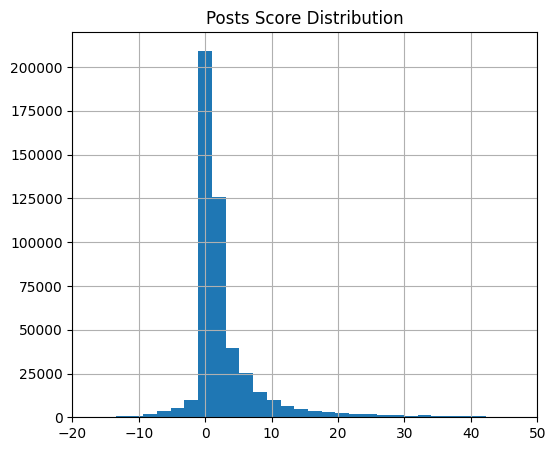

In [11]:
plt.figure(figsize=(6, 5))
df.score.hist(bins=1000)
plt.xlim(-20, 50)
plt.title("Posts Score Distribution")

In [12]:
counts = df.subreddit.value_counts()
percentages = df.subreddit.value_counts(normalize=True) * 100

result = pd.DataFrame({
    'Absolute Count': counts,
    'Percentage': percentages
})

print(result)
# There is some inbalance in the data, 'politics' for example match larger then 'news' reddit group.

               Absolute Count  Percentage
subreddit                                
politics                58608   12.109616
wtf                     43227    8.931586
pics                    41059    8.483633
programming             40080    8.281351
worldnews               36997    7.644340
funny                   29720    6.140762
science                 29583    6.112455
atheism                 29240    6.041584
technology              28358    5.859345
gaming                  17258    3.565857
business                16262    3.360063
entertainment           15727    3.249521
offbeat                 11856    2.449693
economics               11320    2.338944
comics                   8328    1.720736
videos                   7781    1.607714
music                    7139    1.475064
marijuana                6380    1.318239
canada                   5916    1.222367
environment              5450    1.126082
linux                    5173    1.068848
geek                     3900    0

In [13]:
# we not deleted the [deleted] auter so I am removing it here
df1 = df[df.author != '[deleted]']
unique_users = len(df1.author.value_counts())
unique_authors = df1.author.value_counts()
filtered_counts = unique_authors[unique_authors > 10]
print(f'Unique authores {len(unique_authors)}, {len(filtered_counts)}  wrote more then 10 messages each ')

Unique authores 27299, 6867  wrote more then 10 messages each 


In [14]:
# Lets see how many unique authors with politics subredit
df1[df1.subreddit == 'politics'].author.value_counts().head(30)
# There are not so many autors that wrote most of the comments. 

author
chicofaraby           449
FokkeNews             446
malcontent            272
TruthinessHurts       222
innocentbystander     187
WhoKilledTeddyBear    179
monkeyman114          177
nixonrichard          167
IConrad               160
oconostota            155
mexicodoug            150
alllie                135
NoMoreNicksLeft       135
spaceghoti            134
FTR                   123
hs4x                  120
AMerrickanGirl        119
AnnArchist            116
neuromonkey           109
deuteros              108
Deacon                107
braindrane            105
uriel                 104
Dark-Star             104
plbogen               101
garyp714              100
MrDanger               97
mothereffingteresa     97
sigzero                96
Ferrofluid             95
Name: count, dtype: int64

In [15]:
df.date.value_counts().sort_index()
# all the data came from the same month

date
2008-12-01    13819
2008-12-02    17378
2008-12-03    18377
2008-12-04    18118
2008-12-05    17774
2008-12-06    13252
2008-12-07    11983
2008-12-08    16858
2008-12-09    17708
2008-12-10    16870
2008-12-11    17969
2008-12-12    19203
2008-12-13    13598
2008-12-14    12108
2008-12-15    15902
2008-12-16    18289
2008-12-17    17370
2008-12-18    18289
2008-12-19    18010
2008-12-20    13641
2008-12-21    12240
2008-12-22    15361
2008-12-23    16718
2008-12-24    13455
2008-12-25     9935
2008-12-26    11429
2008-12-27    12821
2008-12-28    13153
2008-12-29    16571
2008-12-30    17882
2008-12-31    16352
2009-01-01     1546
Name: count, dtype: int64

# Topic modeling approach to categorize posts

We need to clean the posts, and for that, I'm using the preprocess_text function below.

In [16]:
def preprocess_text(text):
    # Decode HTML entities
    text = html.unescape(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove punctuation and special characters, keeping only alphanumeric and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize, remove stop words, and rejoin
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    # not using too short words
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

In [17]:
df['cleaned_body'] = df['body'].apply(preprocess_text)

In [18]:
words_amount_to_remove = 5
# Here, I'm removing posts that contain fewer than 5 words.
df['cleaned_body_length'] = df.cleaned_body.apply(len)
df = df.sort_values('cleaned_body_length', ascending=True)
df = df[df.cleaned_body_length > words_amount_to_remove]

In [19]:
df.head()

,author,body,created_utc,subreddit,id,score,date,cleaned_body,cleaned_body_length
191393,[deleted],"Jesus christ, did she lick the knife when she ...",2008-12-30 00:29:08,science,6fud,56,2008-12-30,"[jesus, christ, lick, knife, sooo, badass]",6
191534,alllie,"I think the BBC site, especially the Arab vers...",2008-12-30 00:36:29,pics,6g0t,-3,2008-12-30,"[bbc, arab, version, plenty, civilian, victims]",6
197058,trackerbishop,I should have said religion/spirituality rathe...,2008-12-30 06:28:55,atheism,6my2,-4,2008-12-30,"[religionspirituality, christianity, bad, disa...",6
284600,elvisliveson,"With all those zits on him, he might as well h...",2008-12-03 20:30:11,pics,c06n3yo,1,2008-12-03,"[zits, moon, surface, forehead, buffered, even...",6
541938,PocketOSunshine,No mention if he absorbed a twin. How else wo...,2008-12-17 16:08:49,wtf,c06vde8,12,2008-12-17,"[mention, absorbed, twin, feet, brain, weird]",6


In [20]:
df.sort_values('score', ascending=True).head()
# I'm just looking on posts with the lowest Reddit scores.

,author,body,created_utc,subreddit,id,score,date,cleaned_body,cleaned_body_length
486647,ThickGreenPuke,You have no idea how stupid our civilization i...,2008-12-14 19:03:00,pics,c06tjq1,-594,2008-12-14,"[idea, stupid, civilization, modern, science, ...",89
437849,concini,I was going to comment about how I hated you f...,2008-12-11 23:19:24,funny,c06s1gl,-99,2008-12-11,"[comment, hated, simply, copying, linked, post...",14
358251,IAmInLoveWithJesus,I can't speak for the other religious traditio...,2008-12-07 23:16:52,pics,c06pgrs,-97,2008-12-07,"[speak, religious, traditions, christianity, t...",70
360982,IAmInLoveWithJesus,It's a ridiculous idea.\n\nLiberals have this ...,2008-12-08 02:21:31,technology,c06pju5,-93,2008-12-08,"[ridiculous, idea, liberals, pie, sky, belief,...",24
224195,[deleted],"LOL, i can't believe you are continuing this b...",2008-12-31 18:40:31,worldnews,7m9f,-73,2008-12-31,"[lol, continuing, bullshit, wake, kid, fuck, a...",12


# Topic Modeling

In [21]:
preprocessed_docs = df.cleaned_body.values

dictionary = corpora.Dictionary(preprocessed_docs)

# Remove low-frequency terms from the dictionary
dictionary.filter_extremes(no_below=10)

# Create a document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

num_topics = 30
lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=1, chunksize=10000)

In [22]:

for i, topic in lda_model.show_topics(num_topics=num_topics, formatted=False):
    print('Topic {}: {}'.format(i, ', '.join([word[0] for word in topic])))

Topic 0: family, create, hamas, israel, accept, systems, attack, action, stand, normal
Topic 1: position, started, arguments, considered, context, university, moment, belief, china, philosophy
Topic 2: claim, school, code, moral, source, note, happy, news, lies, complex
Topic 3: people, care, rights, majority, sort, natural, health, party, workers, vote
Topic 4: major, prices, months, oil, city, product, peoples, marijuana, smart, gaza
Topic 5: car, pay, cost, force, price, term, body, books, people, light
Topic 6: government, control, jews, social, data, choice, israel, security, power, jobs
Topic 7: reality, definition, argue, physical, children, types, required, person, people, environment
Topic 8: jesus, remember, continue, issues, labor, thousands, gun, christmas, focus, conflict
Topic 9: god, people, human, religious, food, church, subject, follow, belief, national
Topic 10: law, lives, demand, total, situation, resources, blame, time, union, massive
Topic 11: deal, credit, spend

In [23]:
# Load the new document
new_doc = 'Darwin fish bumper stickers and assorted other atheist paraphernalia are available from the Freedom From Religion Foundation in the US.'
# Preprocess the new document
new_doc = preprocess_text(new_doc)

def topic_model_inference(new_doc):
    
    # Create a bag-of-words representation of the new document
    new_doc_bow = dictionary.doc2bow(new_doc)
    
    # Use the LDA model to infer the topic distribution of the new document
    new_doc_topics = lda_model.get_document_topics(new_doc_bow)
    #print(new_doc_topics)
    # Print the top topic for the new document
    #top_topic = max(new_doc_topics, key=lambda x: x[1])[0]
    return new_doc_topics
    
document_topics = topic_model_inference(new_doc)
print('Top Topic for New Document: {}'.format(document_topics))

Top Topic for New Document: [(1, 0.11438934), (6, 0.114263944), (7, 0.11487381), (13, 0.11473473), (14, 0.11509039), (17, 0.114997864), (22, 0.114932865), (23, 0.115099706)]


# Topic modeling outputs to find real-world events in the data over time.

In [24]:
df.reset_index(inplace=True, drop=True)
embeddings = np.zeros((len(df), num_topics))

In [25]:
for row_id, row in df.iterrows():
    document_topics = topic_model_inference(row['cleaned_body'])
    for column_idx, val in document_topics:
        embeddings[row_id, column_idx] = val

In [26]:
grouped_by_date_df = df.groupby('date')
data = np.zeros((len(grouped_by_date_df), num_topics))
date_index = []
for date_counter, (date, group) in enumerate(grouped_by_date_df):
    date_index.append(date)
    
    for i in range(num_topics):
        indexes = group.index.values
        data[date_counter, i] = sum(embeddings[indexes, i])
#dataframe with dates as rows and columns are topic_ids cells are the values of sum over that day.
data_df = pd.DataFrame(data = data, index=date_index)

Lets see the topic #28 which is around israel and see if we can recognize some trends.

Topic 28: israel, people, killed, jews, hamas, attack, palestinians, killing, military, kill

In [27]:
def plot_topic_id(topic_id):
    dates = data_df[topic_id].index
    values = data_df[topic_id].values
    
    # Resample by day and plot
    plt.figure(figsize=(10, 6))
    plt.plot(dates, values, marker='o')
    plt.xlabel("Date")
    plt.ylabel("Number of Entries")
    plt.title(f"Daily Entry Counts topic_id: {topic_id}")
    plt.show()

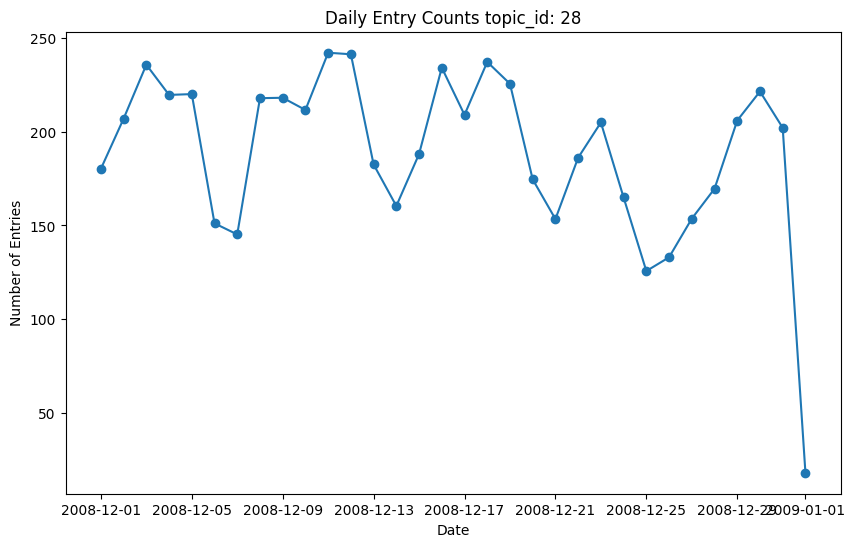

In [28]:
plot_topic_id(28)

We can see the pick in data about war in gaza of 2008.

#### Lets detect the picks in data automaticly 
Each pick supposed to give as some accurance in the world news.

In [29]:

peaks_dict = {}

#topic_trends = df.groupby(['date', 'topic_modeling_topic']).size().unstack(fill_value=0)

#Parameters for significant peaks, those parameters should be tuned.
prominence_threshold = 100
height_threshold = 50    


for topic in data_df.columns:
    data = data_df[topic].values
    peaks, _ = find_peaks(data, prominence=prominence_threshold, height=height_threshold)
    # Store peaks in dictionary
    peaks_dict[topic] = peaks

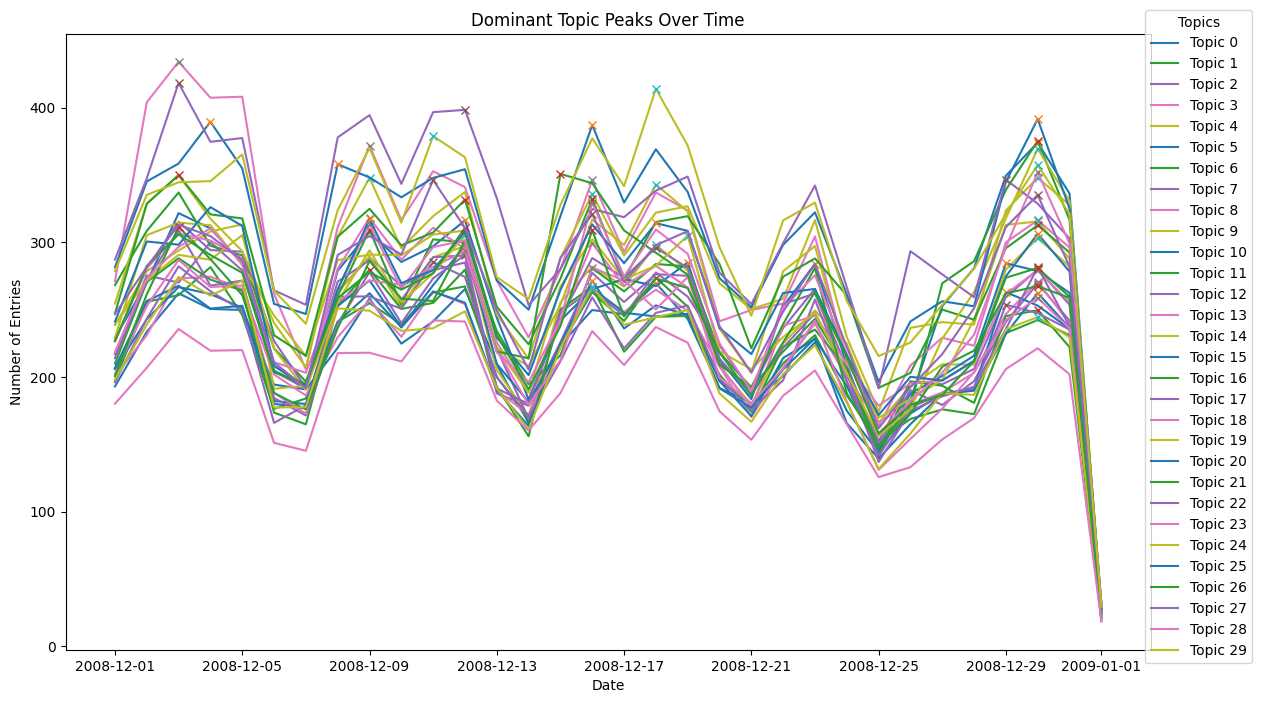

In [30]:
# Plot the data and mark peaks
fig, ax = plt.subplots(figsize=(14, 8))

for topic in data_df.columns:
    # Extract the time series for the current topic
    data = data_df[topic].values
    
    # Plot the topic trend line
    ax.plot(data_df.index, data, label=f"Topic {topic}")
    peaks = peaks_dict[topic]
    # Mark the peaks on the plot
    ax.plot(data_df.index[peaks], data[peaks], "x")

# Customize plot
ax.set_xlabel("Date")
ax.set_ylabel("Number of Entries")
ax.set_title("Dominant Topic Peaks Over Time")
ax.legend(title="Topics", bbox_to_anchor=(1.1, 1.05))

plt.show()

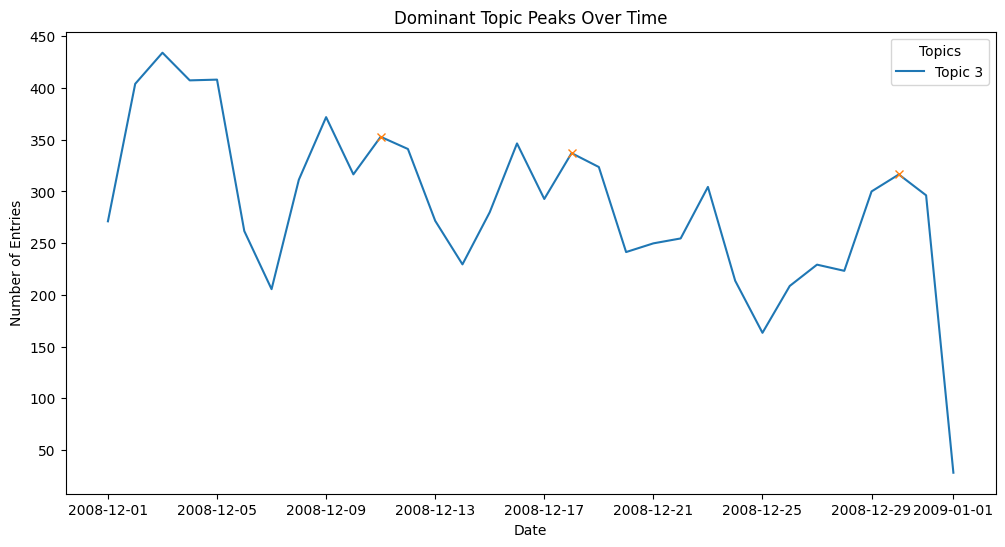

In [31]:
topic = 3
picks = peaks_dict[topic]

# Plot the data and mark peaks
fig, ax = plt.subplots(figsize=(12, 6))

# Extract the time series for the current topic
data = data_df[topic].values
    
# Plot the topic trend line
ax.plot(data_df.index, data, label=f"Topic {topic}")
    
# Mark the peaks on the plot
ax.plot(data_df.index[peaks], data[peaks], "x")

# Customize plot
ax.set_xlabel("Date")
ax.set_ylabel("Number of Entries")
ax.set_title("Dominant Topic Peaks Over Time")
ax.legend(title="Topics")
plt.show()


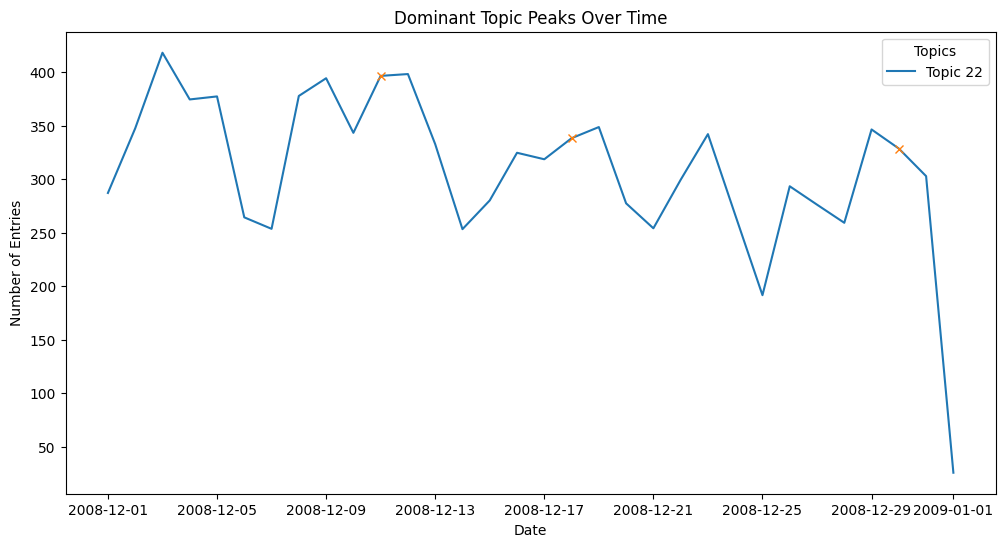

In [32]:
topic = 22

picks = peaks_dict[topic]

# Plot the data and mark peaks
fig, ax = plt.subplots(figsize=(12, 6))

# Extract the time series for the current topic
data = data_df[topic].values
    
# Plot the topic trend line
ax.plot(data_df.index, data, label=f"Topic {topic}")
    
# Mark the peaks on the plot
ax.plot(data_df.index[peaks], data[peaks], "x")

# Customize plot
ax.set_xlabel("Date")
ax.set_ylabel("Number of Entries")
ax.set_title("Dominant Topic Peaks Over Time")
ax.legend(title="Topics")
plt.show()

In [33]:
topic = 3
# Get the row indices where the value in column j is the maximum in that row
row_ids = np.where(np.argmax(embeddings, axis=1) == topic)[0]
list_of_lists  = df.iloc[row_ids].cleaned_body.tolist()

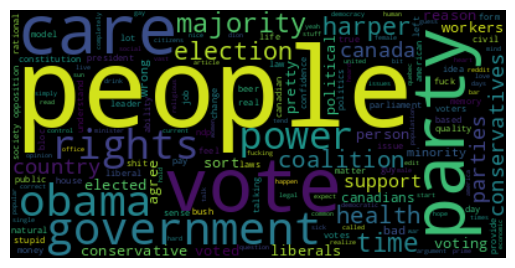

In [34]:
# Read the whole text.
topic = 3



my_list = [item for sublist in list_of_lists for item in sublist]
from collections import Counter
word_could_dict=Counter(my_list)

# Generate a word cloud image
wordcloud = WordCloud().generate_from_frequencies(word_could_dict)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Evaluate your topic modeling results using the subreddit column.

In [35]:
labels = df.subreddit.values.tolist()

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [37]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)


In [38]:
# Initialize a classifier, e.g., RandomForestClassifier
clf = LogisticRegression(solver='saga')

In [39]:
# Train the classifier
clf.fit(X_train, y_train)

LogisticRegression(solver='saga')

In [40]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

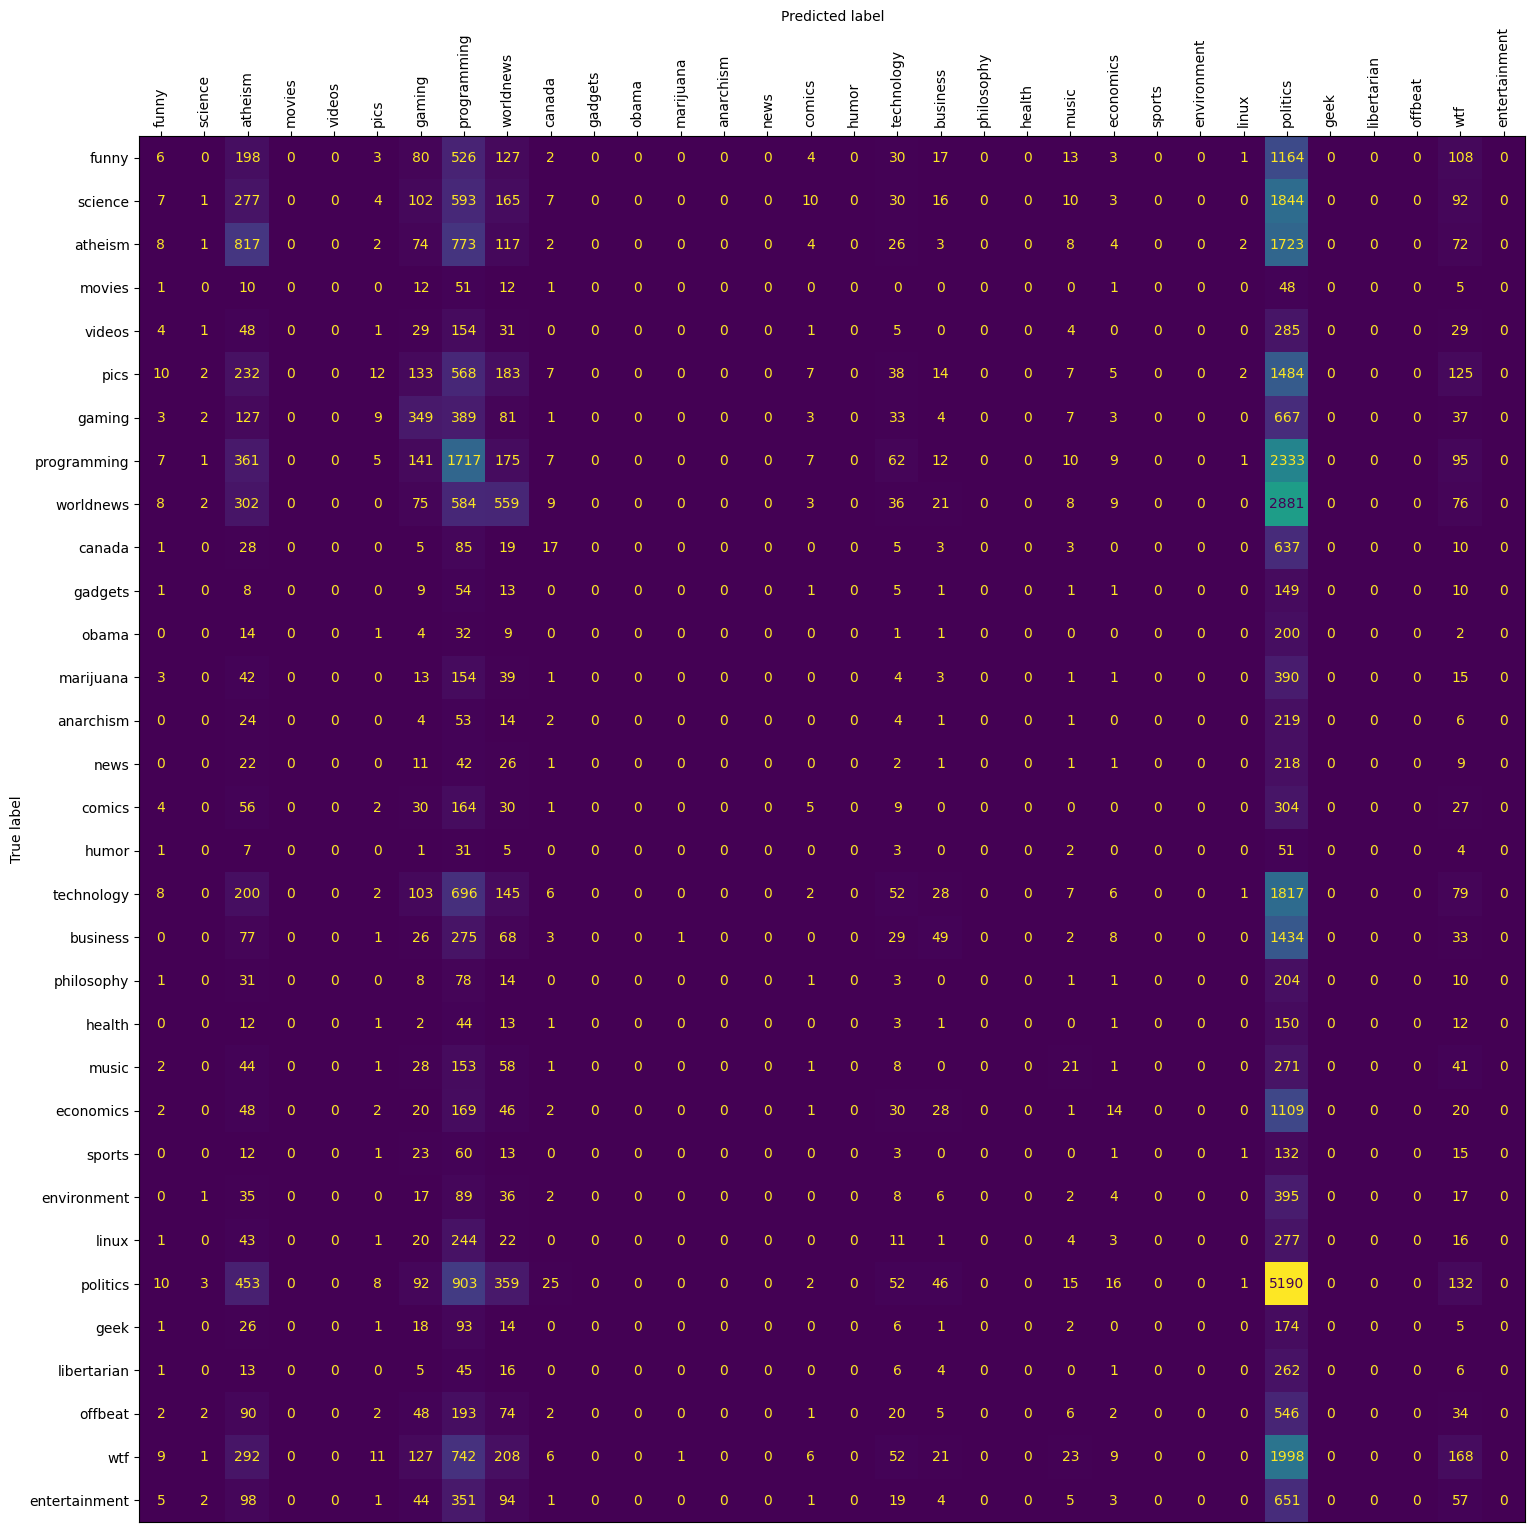

In [42]:
unique_labels = list(set(y_test))
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)

fig, ax = plt.subplots(figsize=(18, 18))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = unique_labels)
disp.plot(colorbar=False, ax=ax)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()